In [1]:
%matplotlib inline

import pymysql.cursors
import json
import pandas as pd

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             db='consultation_an',
                             charset='latin1',
                             cursorclass=pymysql.cursors.DictCursor)

In [2]:
results = []
affirmations = [
    "des analyses ou proposition d'ordre général",
    "des prises de position contre une mesure existante",
    "des prises de position en faveur d'une mesure existante",
    "des propositions de nouvelles mesures",
    "des questions ou demandes d'information",
    "l'évocation d'expérience(s) personnelle(s)",
    "une analyse des causes du problème",
    "une description d'un problème"]

affirmations_short = [
    'analyse ou proposit°',
    'contre 1 mesure',
    'pour 1 mesure',
    'nouvelles mesures',
    'questions',
    'XP personnelle',
    'analyse des causes',
    'description pb'
]
usage = ["cite", "prend en compte", "recois", "rien", "éclaircir"]
usage_label = ["cite", "prend en compte", "reçoit", "ne fait rien", "demande à éclaircir"]
def build_result(row):
    data = json.loads(row['data'])
    if type(data) != str:
        if 'affirmations' in data:
            row['affirmations'] = data['affirmations']
            for p, p_short in zip(affirmations, affirmations_short):
                if p in data['affirmations']:
                    row[p_short] = 1
                else:
                    row[p_short] = 0
                
        if 'original' in data:
            row['original'] = 1 if "oui" in data['original'] else 0
        
        if 'usage' in data :
            for p, p_label in zip(usage, usage_label):
                if p in data['usage']:
                    row[p_label] = 1
                else:
                    row[p_label] = 0
            
    row.pop('data')
    return row
    
with connection.cursor() as cursor:
    sql = "SELECT `document_id`, `data`, documents.source, documents.theme, documents.question, documents.text FROM `tasks` INNER JOIN `documents` ON documents.id = tasks.document_id"
    cursor.execute(sql)
    results = [build_result(row) for row in cursor.fetchall()]

In [3]:
df = pd.DataFrame(data=results)
df.to_csv('crowdsourcing_consultation_an.csv', float_format='%.0f')
df.head()

,XP personnelle,affirmations,analyse des causes,analyse ou proposit°,cite,contre 1 mesure,demande à éclaircir,description pb,document_id,ne fait rien,nouvelles mesures,original,pour 1 mesure,prend en compte,question,questions,reçoit,source,text,theme
0,0.0,"[des analyses ou proposition d'ordre général, ...",0.0,1.0,1.0,0.0,0.0,0.0,339,0.0,1.0,1.0,0.0,0.0,Si vous avez dautres informations ou expérien...,0.0,0.0,lpyWm20=/31,Sans rapport avec les pensions impayées mais e...,4
1,0.0,[des propositions de nouvelles mesures],0.0,0.0,0.0,0.0,0.0,0.0,271,0.0,1.0,1.0,0.0,1.0,Si vous avez dautres informations ou expérien...,0.0,0.0,lpyclm0=/26,L'élaboration d'un guide à destination des par...,3
2,0.0,"[une description d'un problème, des propositio...",0.0,0.0,1.0,0.0,0.0,1.0,43,0.0,1.0,1.0,0.0,0.0,Si vous avez dautres informations ou expérien...,0.0,0.0,lpyWlWc=/16,-faire connaître les dispositifs de signalemen...,2
3,0.0,[des propositions de nouvelles mesures],0.0,0.0,0.0,0.0,0.0,0.0,74,0.0,1.0,0.0,0.0,1.0,Si vous avez dautres informations ou expérien...,0.0,0.0,lpyYl2Y=/16,Programmer des dessins animés pour le public e...,2
4,1.0,"[l'évocation d'expérience(s) personnelle(s), u...",1.0,0.0,0.0,0.0,0.0,0.0,519,0.0,0.0,0.0,0.0,1.0,Si vous avez dautres informations ou expérien...,0.0,0.0,lp2VlGY=/40,Simplement que l'on écoute les femmes lorsqu'e...,5


## Éléments des contributions identifiés par les rapporteurs

1.1580340264650284

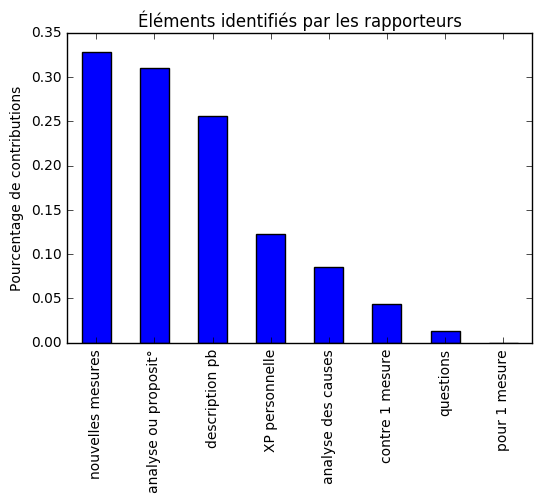

In [4]:
affirmations_total = df[affirmations_short].sum() / df.shape[0]
affirmations_total.sort_values(ascending=False, inplace=True)
plot = affirmations_total.plot(
    kind='bar',
    title='Éléments identifiés par les rapporteurs')
plot.set_ylabel('Pourcentage de contributions')
affirmations_total.sum()

## Originalité des contributions

In [5]:
original = df[['original']].sum() / df.shape[0]
original

original    0.306616
dtype: float64

## Propos les + intéressants

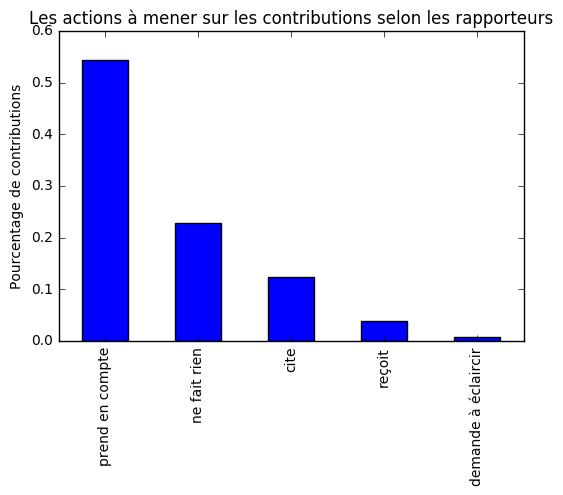

In [6]:
usage_total = df[usage_label].sum() / df.shape[0]
usage_total.sort_values(inplace=True, ascending=False)
plot = usage_total.plot(
    kind='bar',
    title='Les actions à mener sur les contributions selon les rapporteurs')
plot.set_ylabel('Pourcentage de contributions')

# Validation des contributions : quelle méthode ?

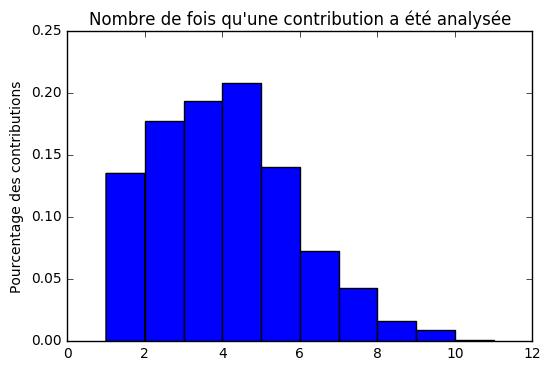

In [7]:
gp_by_document = df.groupby('document_id')
count_by_document = gp_by_document.document_id.count()
count_by_document.sort_values(ascending=False, inplace=True)
plot = count_by_document.plot(
    kind='hist',
    normed=True,
    title='Nombre de fois qu\'une contribution a été analysée')
plot.set_ylabel('Pourcentage des contributions')

In [8]:
def validation_method_1(data):
    # méthode en production : éléments + originalité
    return data[affirmations_short + ['original']].duplicated().sum() > 2

def validation_method_2(data):
    # seulement sur les éléments
    return data[affirmations_short].duplicated().sum() > 2

def validation_method_3(data):
    # ok si au moins un élement est retrouvé 3x + originalité
    for p in affirmations_short:
        if data[[p, 'original']].duplicated().sum() > 2:
            return True
        
    return False

score = {'method_1': 0, 'method_2': 0, 'method_3': 0}
document_count = len(df.document_id.unique())
for _, group in gp_by_document:
    if validation_method_1(group):
        score['method_1'] += 1 / document_count
    if validation_method_2(group):
        score['method_2'] += 1 / document_count
    if validation_method_3(group):
        score['method_3'] += 1 / document_count

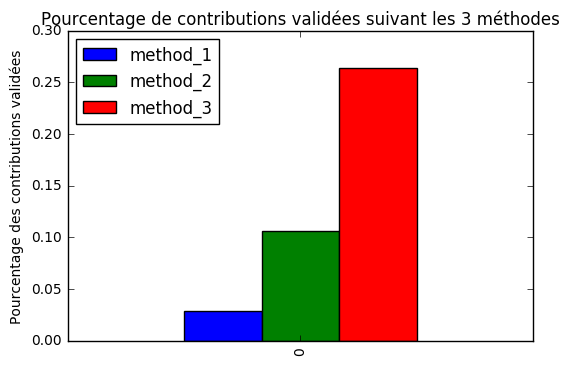

In [9]:
plot = pd.DataFrame(data=[score]).plot(
    kind='bar',
    title='Pourcentage de contributions validées suivant les 3 méthodes')
plot.set_ylabel('Pourcentage des contributions validées')

In [ ]:
score

{'method_1': 0.028455284552845534,
 'method_2': 0.10569105691056892,
 'method_3': 0.2642276422764232}

In [ ]:
score = {}
for a in affirmations_short:
    for b in affirmations_short:
        if a == b:
            continue
        if b+" <-> "+a in score.keys():
            continue
        score[a+" <-> "+b] = 0
        print(a+" <-> "+b)
        for _, group in gp_by_document:
            group.loc[a] = ((group[b] + group[a]) >= 1) * 1
            group.loc[b] = ((group[b] + group[a]) >= 1) * 1
            if validation_method_2(group):
                score[a+" <-> "+b] += 1 / document_count
        print(score[a+" <-> "+b])

In [ ]:
pd.DataFrame(data=[score]).T.sort_values(by=0)